# Task
Predict annual water usage in Baltimore

In [1]:
# Mounting Google drive

from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Biased Outliers/Book Study Group/Introduction to Time Series Forecasting with Python/data/"
DATA = 'yearly-water-usage.csv'

Mounted at /content/drive


In [2]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [3]:
# Reading in the data

df = pd.read_csv(PATH+DATA, index_col=0, parse_dates=True)
df.head()

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413


In [4]:
# Viewing the shape of the data

df.shape

(79, 1)

In [5]:
# Viewing the range of dates

print(f"Time range: {df.index.min()} - {df.index.max()}")

Time range: 1885-01-01 00:00:00 - 1963-01-01 00:00:00


In [6]:
# Checking if there are any duplicate years

np.sum(df.index.value_counts() > 1)

0

In [7]:
# Checking the summary statistics

df.describe()

,Water
count,79.000000
mean,512.025316
std,75.685072
min,344.000000
25%,462.000000
50%,503.000000
75%,581.000000
max,662.000000


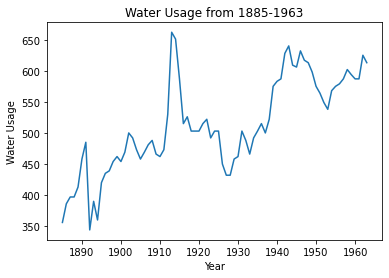

In [8]:
# Plotting the time series

plt.plot(df)
plt.title('Water Usage from 1885-1963')
plt.xlabel('Year')
plt.ylabel('Water Usage');

* there is an upward trend
* there might be some seaonality within 20 years
  * it seems like to spike up and then spike down a bit
* big spike around the year 1912-1915

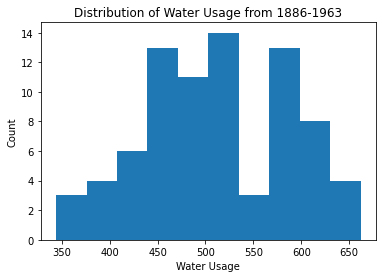

In [9]:
# Viewing the distribution

plt.hist(df['Water'])
plt.title('Distribution of Water Usage from 1886-1963')
plt.xlabel('Water Usage')
plt.ylabel('Count');

In [10]:
# Splitting the data

split_point = df.shape[0] - 10
train, valid = df[:split_point], df[split_point:]
print(f'Train: {train.shape}, Valid: {valid.shape}')

Train: (69, 1), Valid: (10, 1)


In [11]:
# Converting train into series

series = pd.Series(train['Water'])

In [12]:
# Splitting the data further into train and test

X = series.values
X = X.astype('float32')
train_size = int(len(X)*0.5)
train, test = X[0:train_size], X[train_size:]

In [13]:
# Walk-Forward Validation

history = [x for x in train]
predictions = []

for i in range(len(test)):
  
  ## Predictions using Persistance Model
  yhat = history[-1]
  predictions.append(yhat)

  ## Observations
  obs = test[i]
  history.append(obs)
  print(f'>Predicted: {yhat:.3f}, Expected: {obs:.3f}')

## Calculating RMSE for Persistance Model
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"RMSE: {rmse:.3f}")

>Predicted: 503.000, Expected: 503.000
>Predicted: 503.000, Expected: 503.000
>Predicted: 503.000, Expected: 515.000
>Predicted: 515.000, Expected: 522.000
>Predicted: 522.000, Expected: 492.000
>Predicted: 492.000, Expected: 503.000
>Predicted: 503.000, Expected: 503.000
>Predicted: 503.000, Expected: 450.000
>Predicted: 450.000, Expected: 432.000
>Predicted: 432.000, Expected: 432.000
>Predicted: 432.000, Expected: 458.000
>Predicted: 458.000, Expected: 462.000
>Predicted: 462.000, Expected: 503.000
>Predicted: 503.000, Expected: 488.000
>Predicted: 488.000, Expected: 466.000
>Predicted: 466.000, Expected: 492.000
>Predicted: 492.000, Expected: 503.000
>Predicted: 503.000, Expected: 515.000
>Predicted: 515.000, Expected: 500.000
>Predicted: 500.000, Expected: 522.000
>Predicted: 522.000, Expected: 575.000
>Predicted: 575.000, Expected: 583.000
>Predicted: 583.000, Expected: 587.000
>Predicted: 587.000, Expected: 628.000
>Predicted: 628.000, Expected: 640.000
>Predicted: 640.000, Expe

## Data Analysis

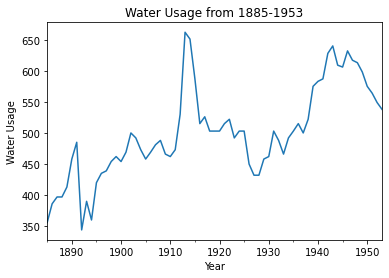

In [14]:
# Plotting a line plot

series.plot();
plt.title('Water Usage from 1885-1953')
plt.xlabel('Year')
plt.ylabel('Water Usage');

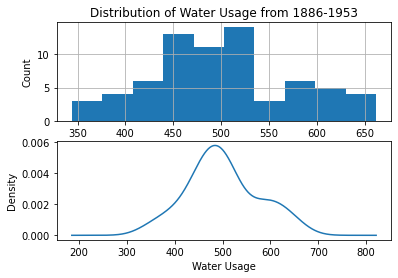

In [15]:
# Plotting density plot

plt.figure(1)

plt.subplot(2,1,1)
series.hist()
plt.title('Distribution of Water Usage from 1886-1953')
plt.ylabel('Count');

plt.subplot(2,1,2)
series.plot(kind='kde')
plt.xlabel('Water Usage')
plt.show()

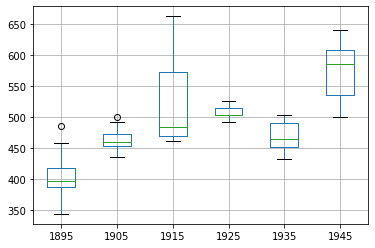

In [16]:
# Boxplots for each decade

## Grouping by decade
groups = series.groupby(pd.Grouper(freq='10Y'))
decades = pd.DataFrame()

for name, group in groups:
  if len(group.values) is 10:
    decades[name.year] = group.values
decades.boxplot()
plt.show()

* the median shows a non-linear positive trend
* the spread shows some variabiity
* there are some outliers in the first two decades
* second to last decade seems to have a lower average consumption

In [17]:
# Function that differences the time series

def difference(df):
  diff = []
  for i in range(1, len(df)):
    value = df[i] - df[i-1]
    diff.append(value)
  return pd.Series(diff)

In [18]:
# Differencing the data

stationary = difference(X)
stationary.index = series.index[1:]

In [19]:
# Checking if the series is stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(stationary)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
  print(f'\t{key}: {value:.3f}')

ADF Statistic: -6.126718808474715
p-value: 8.593851954694127e-08
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


the ADF statistic is smaller than the critical value at 1%
* reject the null hypothesis with a significance level of less than 1$
  * the process has no unit root
  * time series is stationary
* suggest that differencing is needed
  * at least d = 1

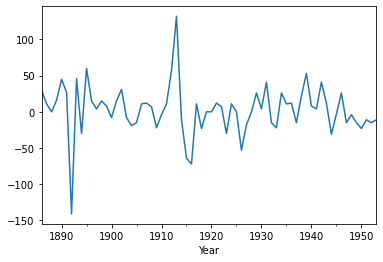

In [20]:
# Plotting the stationary series

stationary.plot()
plt.show()

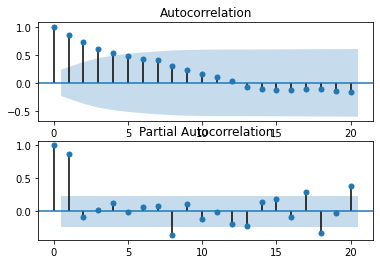

In [21]:
# Plotting ACF and PACF to determine p and q of ARIMA

import statsmodels.graphics.tsaplots as tsa

## Creating the figure
plt.figure()

## Creating the first plot
plt.subplot(2,1,1)
tsa.plot_acf(series, lags=20, ax=plt.gca())

## Creating the second plot
plt.subplot(2,1,2)
tsa.plot_pacf(series, lags=20, ax=plt.gca())
plt.show()

* the ACF shows significant lags to 4 time steps
* PACF shows significant lags to 1 time step

In [22]:
from statsmodels.tsa.arima_model import ARIMA

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
  model = ARIMA(history, order=(4,1,1))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)

  obs = test[i]
  history.append(obs)
  print(f'>Predicted: {yhat[0]:.3f}, Expected: {obs:.3f}')
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"RMSE: {rmse:.3f}")

>Predicted: 548.319, Expected: 503.000
>Predicted: 545.085, Expected: 503.000
>Predicted: 546.061, Expected: 515.000
>Predicted: 550.660, Expected: 522.000
>Predicted: 552.011, Expected: 492.000
>Predicted: 519.221, Expected: 503.000
>Predicted: 527.953, Expected: 503.000
>Predicted: 534.026, Expected: 450.000
>Predicted: 474.119, Expected: 432.000
>Predicted: 456.458, Expected: 432.000
>Predicted: 465.408, Expected: 458.000
>Predicted: 481.425, Expected: 462.000
>Predicted: 476.155, Expected: 503.000
>Predicted: 511.083, Expected: 488.000
>Predicted: 497.183, Expected: 466.000
>Predicted: 460.301, Expected: 492.000
>Predicted: 506.310, Expected: 503.000
>Predicted: 515.928, Expected: 515.000
>Predicted: 516.368, Expected: 500.000
>Predicted: 504.364, Expected: 522.000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


>Predicted: 525.885, Expected: 575.000
>Predicted: 579.358, Expected: 583.000
>Predicted: 575.313, Expected: 587.000
>Predicted: 573.357, Expected: 628.000
>Predicted: 622.134, Expected: 640.000
>Predicted: 632.300, Expected: 609.000
>Predicted: 595.782, Expected: 606.000
>Predicted: 602.448, Expected: 632.000
>Predicted: 635.946, Expected: 617.000
>Predicted: 614.239, Expected: 613.000
>Predicted: 609.030, Expected: 598.000
>Predicted: 601.829, Expected: 575.000
>Predicted: 580.316, Expected: 564.000
>Predicted: 574.084, Expected: 549.000
>Predicted: 562.009, Expected: 538.000
RMSE: 31.097


## Grid Search

In [23]:
# # evaluate an ARIMA model for a given order (p,d,q) and return RMSE
# def evaluate_arima_model(X, arima_order): 
#   # prepare training dataset
#   X = X.astype('float32')
#   train_size = int(len(X) * 0.50)
#   train, test = X[0:train_size], X[train_size:]
#   history = [x for x in train]
#   # make predictions
#   predictions = list()
#   for t in range(len(test)):
#     model = ARIMA(history, order=arima_order) # model_fit = model.fit(disp=0)
#     model_fit = model.fit(trend='nc', disp=0) 
#     yhat = model_fit.forecast()[0] 
#     predictions.append(yhat) 
#     history.append(test[t])
#   # calculate out of sample error
#   rmse = np.sqrt(mean_squared_error(test, predictions))
#   return rmse

# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values): 
#   dataset = dataset.astype('float32')
#   best_score, best_cfg = float("inf"), None
#   for p in p_values:
#     for d in d_values:
#       for q in q_values:
#         order = (p,d,q)
#         try:
#           rmse = evaluate_arima_model(dataset, order)
#           if rmse < best_score:
#             best_score, best_cfg = rmse, order 
#           print('ARIMA%s RMSE=%.3f' % (order,rmse))
#         except:
#           continue
#   print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# # evaluate parameters
# p_values = range(0, 5)
# d_values = range(0, 3)
# q_values = range(0, 5)
# warnings.filterwarnings("ignore")
# evaluate_models(series.values, p_values, d_values, q_values)

* Running the Grid Search gives values ARIMA(2, 1, 0) as the best values

## Reviewing the Residual Errors

In [24]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
  model = ARIMA(history, order=(2,1,0))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)

  obs = test[i]
  history.append(obs)
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print(f'RMSE: {rmse:.3f}')

RMSE: 21.733


In [25]:
# Collecting the residuals

residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

               0
count  35.000000
mean    1.081625
std    22.022566
min   -52.103812
25%   -16.202280
50%    -0.459805
75%    12.085093
max    51.284333


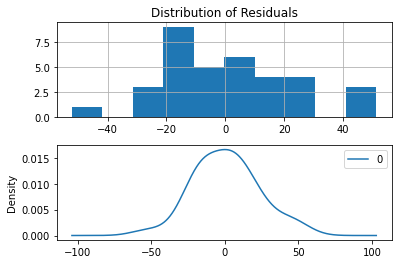

In [26]:
# Plotting the residuals

plt.figure()
plt.subplot(2,1,1)
residuals.hist(ax=plt.gca())
plt.title("Distribution of Residuals")

plt.subplot(2,1,2)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

The mean of the residuals is 1.08 so the predictions should be corrected by that much.

In [27]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = []
bias = residuals.mean()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(2,1,0)) 
  model_fit = model.fit(trend='nc', disp=0) 
  yhat = bias + float(model_fit.forecast()[0]) 
  predictions.append(yhat)
  
  # observation
  obs = test[i]
  history.append(obs)

# report performance
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print(f'RMSE: {rmse:.3f}')

RMSE: 21.706


In [28]:
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))] 
residuals = pd.DataFrame(residuals)
print(residuals.describe())

                  0
count  3.500000e+01
mean   6.496391e-15
std    2.202257e+01
min   -5.318544e+01
25%   -1.728390e+01
50%   -1.541429e+00
75%    1.100347e+01
max    5.020271e+01


## Validating the Model

In [29]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
  return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

In [30]:
# prepare data
X = series.values
X = X.astype('float32')

# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)

# bias constant, could be calculated from in-sample mean residual bias = 1.081624
# save model
model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])

In [31]:
from statsmodels.tsa.arima_model import ARIMAResults

model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0]) 
print(f'Predicted: {yhat[0][0]:.3f}')

Predicted: 540.013


In [32]:
# Processing the validation data

y = pd.Series(valid['Water'])
y = y.values.astype('float32')
y

array([568., 575., 579., 587., 602., 594., 587., 587., 625., 613.],
      dtype=float32)

In [33]:
# Loading the model and bias

model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')

In [34]:
# Making the first prediction

predictions = []
yhat = bias + float(model_fit.forecast()[0]) 
predictions.append(yhat[0])
history.append(y[0])

In [35]:
# Rolling forecast

for i in range(1, len(y)):
  ## Predicting
  model = ARIMA(history, order=(2,1,0))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = bias + float(model_fit.forecast()[0]) 
  predictions.append(yhat[0])
  
  ## Observation
  obs = y[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

>Predicted=571.589, Expected=575.000
>Predicted=573.289, Expected=579.000
>Predicted=579.561, Expected=587.000
>Predicted=588.063, Expected=602.000
>Predicted=603.022, Expected=594.000
>Predicted=593.178, Expected=587.000
>Predicted=588.558, Expected=587.000
>Predicted=588.797, Expected=625.000
>Predicted=627.941, Expected=613.000


In [36]:
# Calculating the RMSE

rmse = np.sqrt(mean_squared_error(y, predictions))
print(f'RMSE: {rmse:.3f}')

RMSE: 16.532


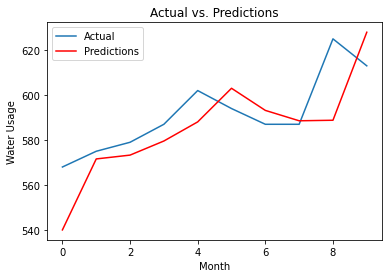

In [37]:
# Plotting predictions and actual

plt.plot(y, label='Actual')
plt.plot(predictions, color='red', label='Predictions')
plt.title('Actual vs. Predictions')
plt.xlabel('Month')
plt.ylabel('Water Usage')
plt.legend()
plt.show()